1. 加载数据
2. 搜索最佳参数
3. 可视化
4. 存标签

In [17]:
import os
import shutil
from tqdm import tqdm
import random
import math
from glob import glob

import pickle as pkl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans


In [18]:
# get the current directory
proj_root_dir = os.path.abspath(os.path.join(os.getcwd(),".."))
print("proj_root_dir: ", proj_root_dir)

proj_root_dir:  /data1/home/xiruiling/course/AdvanceArtificialIntelligence/AAI_Proj


In [19]:
# load
tSNE_result_dir = os.path.join(proj_root_dir, 'state_dict', 'tSNE.pkl')
with open(tSNE_result_dir, 'rb') as f:
    tSNE_result = pkl.load(f)

idx_dir = os.path.join(proj_root_dir, 'state_dict', 'fft_result_wo_simplify', 'trnIdx.pkl')
with open(idx_dir, 'rb') as f:
    Idx = pkl.load(f)

# print(tSNE_result)
print(len(Idx))

pd.reset_option('display.float_format')
tSNE_result_pd = pd.DataFrame(tSNE_result)
tSNE_result_pd


251


,0,1
0,1.507830e-05,-0.000004
1,-6.498275e-07,-0.000004
2,-1.615160e-06,0.000002
3,2.749594e-07,0.000001
4,-2.126513e-07,-0.000007
...,...,...
890827,1.003639e-06,-0.000006
890828,-2.587970e-06,0.000008
890829,-4.225471e-06,0.000013
890830,-4.308719e-06,-0.000003


In [ ]:
# Search parameters
parameters = [16, 12, 20, 24]

# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})

best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []

# evaluation based on silhouette_score
for p in tqdm(parameter_grid):
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(tSNE_result_pd)          # fit model on wine dataset, this will find clusters based on parameter p
    with open(os.path.join('/data1/home/xiruiling/course/AdvanceArtificialIntelligence/AAI_Proj/state_dict/knn_model', 'knn_'+str(p)+'_.pkl'), 'wb') as f:
        pkl.dump(kmeans_model, f)
    ss = metrics.silhouette_score(tSNE_result_pd, kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores

    print('Parameter:', p, 'Score', ss)

    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p

# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

best_grid['n_clusters']

In [ ]:
optimum_num_clusters = best_grid['n_clusters']
print("optimum num of clusters =", optimum_num_clusters)

In [70]:
# get the centroids
kmeans = KMeans(n_clusters=16)
with open(os.path.join(proj_root_dir, 'state_dict', 'knn_model', 'knn_16.pkl'), 'rb') as f:
    kmeans = pkl.load(f)
# kmeans.fit(tSNE_result_pd)
centroids = kmeans.cluster_centers_
centroids
# centroids_tSNE = tSNE_result_pd.transform(centroids)

array([[-2.3159400e-06, -3.2884063e-06],
       [-2.0572604e-06,  8.4188632e-06],
       [-9.2503527e-05, -2.8756668e-04],
       [-1.1008627e-06,  2.0292432e-06],
       [ 1.4721555e-05, -7.4850163e-07],
       [ 5.2288233e-06, -6.8752315e-06],
       [ 4.0581172e-06,  4.4021454e-06],
       [-6.3624764e-05, -4.0724708e-06],
       [-2.6755088e-05, -5.2049862e-05],
       [ 8.4721585e-05,  4.3539050e-05],
       [-7.2216199e-06,  3.2931592e-05],
       [-2.9943601e-04, -3.2771478e-04],
       [-4.5875472e-06, -1.3613678e-05],
       [ 2.4373699e-06, -1.6116455e-06],
       [-8.6066888e-05,  9.4792034e-05],
       [-8.9812238e-06, -6.8922594e-07]], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


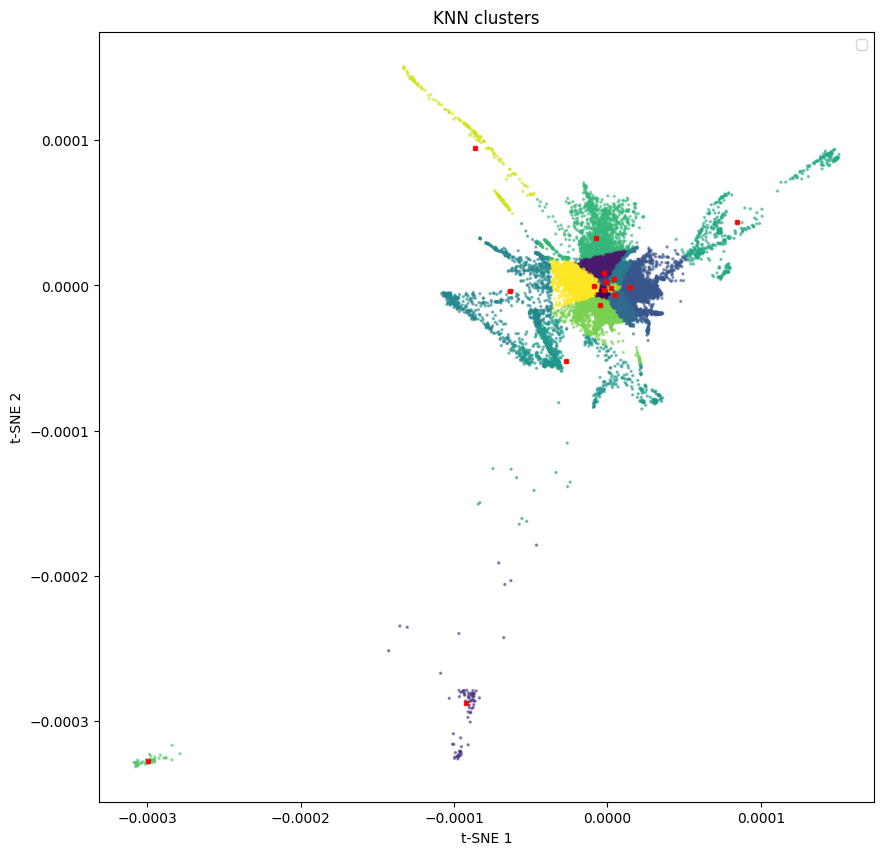

In [34]:
# Visualization

x = tSNE_result[:, 0]
y = tSNE_result[:, 1]

plt.figure(figsize=(10,10))
plt.scatter(x, y, c=kmeans.labels_, alpha=0.5, s=2)  # plot different colors per cluster
plt.scatter(centroids[:,0] , centroids[:,1] , s = 10, marker='X', color = 'red')

plt.title('KNN clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
# plt.scatter(knn_result[:, 0], knn_result[:, 1], marker='X', s=200, linewidths=1.5,
#             color='red', edgecolors="black", lw=1.5)

plt.show()

In [57]:
kmeans.labels_
np.unique(np.array(kmeans.labels_))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int32)

In [71]:
labels = kmeans.labels_

final_result = np.zeros((len(Idx)-1, 2))
for i in range(len(Idx)-1):
    final_result[i][0] = i
    majority_vote_record = np.zeros((16))
    for j in range(Idx[i], Idx[i+1]):
        majority_vote_record[labels[j]] = majority_vote_record[labels[j]] + 1
    final_result[i][1] = np.argmax(np.array(majority_vote_record))
    # print(j, "th speaker record: ", majority_vote_record)
    # print("vote: ", np.argmax(np.array(majority_vote_record)), "\n")

np.save(os.path.join(proj_root_dir, 'state_dict', 'knn_specialty'), final_result)
specialty_record = np.zeros((16))
for i in range(len(Idx)-1):
    specialty_record[int(final_result[i][1])] = specialty_record[int(final_result[i][1])] + 1

specialty_record

array([ 18.,  27.,   0., 134.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,  69.,   0.,   1.])